# Load the data
- read table
- fix values
- normalize by number of repeats
- calculate derived columns

In [37]:
import pandas as pd
import numpy as np

def int_core_name(v):
    return v[:v.find('_')]

def assembly_core(s):
    return s.removesuffix('Assembly')

def safe_none(fn):
    def _fn(v):
        try:
            return fn(v)
        except AttributeError:
            return None
    
    return _fn

def read_table(fpath):
    """
    Read the file, define columns translate to the xarray.
    Original columns:
    commit, 
    run_id, 
    domain_shape, uniformity->mesh_size, spacedim, mesh_size->uniformity, 
     
    field_variant, assembly_variant, assembly_class, integral_type,
    tag,  time, n_repeats,
    time_fraction, time_fraction_of_reminder
    """
    with open(fpath, "r") as f:
        df = pd.read_csv(f)
    
    # fix column names
    df['uniformity'], df['mesh_size'] = df['mesh_size'], df['uniformity'] 
    
    # fix integral names
    df['integral_type'] = [safe_none(fix_int_name)(v) for v in df['integral_type']]
    
    # unify 'cube' and 'square' to 'box'
    shape_map = {'square': 'B', 'cube':'B', 'lshape': 'L'}
    df['domain_shape'] = [shape_map[s] for s in df['domain_shape']]
    
    # simpler assembly names: Mass, Stiffness, Sources
    print(df['assembly_class'])
    df['assembly'] = [safe_none(assembly_core)(s) for s in df['assembly_class']]
    
    # add mesh sizes
    size_map = {'small':1, 'medium':2, 'big':3}
    df['n_elements'] = [size_map[mesh_size] * 1000 for mesh_size in df['mesh_size']]
    
    # add calls
    df['n_calls'] = 1
    
    # normalize by 'n_repeats'
    df['time'] /= df['n_repeats']
    df['n_calls'] /= df['n_repeats']
    df.drop(columns=['n_repeats', 'assembly_class',], inplace=True)
    
    df.set_index(['commit', 'spacedim', 'domain_shape', 'uniformity',  'mesh_size', 'run_id'], inplace=True)
    #code_map['']
    #df['code'] = [code_map[av] for av in df['assembly_variant']]
    return df

input_file_base ="../dg_asm-1-bench_profiler" 
df = read_table(input_file_base + ".csv")
display(df)

# Print values of distrete columns:
for c in df.columns:
    if df[c].dtype.name == 'object':
        print(c, '  values:', df[c].unique())


0                   NaN
1                   NaN
2                   NaN
3                   NaN
4                   NaN
             ...       
6115    SourcesAssembly
6116    SourcesAssembly
6117    SourcesAssembly
6118    SourcesAssembly
6119    SourcesAssembly
Name: assembly_class, Length: 6120, dtype: object


field_variant  \
commit  spacedim domain_shape uniformity mesh_size run_id                 
a044dad 2D       B            uniform    small     1                NaN   
                                         medium    1                NaN   
                                         big       1                NaN   
                              refined    small     1                NaN   
                                         medium    1                NaN   
...                                                                 ...   
        3D       L            refined    big       3              model   
                                                   3              model   
                                                   3              model   
                                                   3              model   
                                                   3              model   

                                                          assembly_variant  \
commit  spacedim domain_shape uniformity mesh_size run_id                    
a044dad 2D       B            uniform    small     1                   NaN   
                                         medium    1                   NaN   
                                         big       1                   NaN   
                              refined    small     1                   NaN   
                                         medium    1                   NaN   
...                                                                    ...   
        3D       L            refined    big       3            EvalFields   
                                                   3            EvalFields   
                                                   3            EvalFields   
                                                   3            EvalFields   
                                                   3            EvalFields   

                                                                                 tag  \
commit  spacedim domain_shape uniformity mesh_size run_id                              
a044dad 2D       B            uniform    small     1                       full_mesh   
                                         medium    1                       full_mesh   
                                         big       1                       full_mesh   
                              refined    small     1                       full_mesh   
                                         medium    1                       full_mesh   
...                                                                              ...   
        3D       L            refined    big       3                    cache_update   
                                                   3       assemble_volume_integrals   
                                                   3        assemble_fluxes_boundary   
                                                   3       assemble_fluxes_elem_elem   
                                                   3       assemble_fluxes_elem_side   

                                                          integral_type  \
commit  spacedim domain_shape uniformity mesh_size run_id                 
a044dad 2D       B            uniform    small     1               None   
                                         medium    1               None   
                                         big       1               None   
                              refined    small     1               None   
                                         medium    1               None   
...                                                                 ...   
        3D       L            refined    big       3               None   
                                                   3               cell   
                                                   3           boundary   
                                                   3               edge   
                      

field_variant   values: [nan 'const' 'model']
assembly_variant   values: [nan 'FullAssembly' 'ComputeLocal' 'EvalFields']
tag   values: ['full_mesh' 'MassAssembly' 'create_patch' 'cache_update'
 'assemble_volume_integrals' 'assemble_fluxes_boundary'
 'assemble_fluxes_elem_elem' 'assemble_fluxes_elem_side'
 'StiffnessAssembly' 'SourcesAssembly']
integral_type   values: [None 'cell' 'boundary' 'edge' 'dimjoin']
assembly   values: [None 'Mass' 'Stiffness' 'Sources']


# Overall structure
Let us compare individual meshes and their composition from assembly classes.

In [39]:
def top_tags(df):
    """
    Extract just top level tags passing over the whole mesh.
    """
    top_tags = {'full_mesh', 'MassAssembly', 'StiffnessAssembly', 'SourcesAssembly'}
    df['Variants'] = df.apply(lambda row: f"{row['field_variant']}_{row['assembly_variant']}", axis=1)
    df2 = df[df['tag'].isin(top_tags)].copy()
    
    df2.dropna(axis='columns', how='all', inplace=True)
    return df2[['Variants', 'tag', 'time']]
    
df_top_tags = top_tags(df)
display(df_top_tags)

unique_combinations = df_top_tags.index.unique()

# Iterate over unique combinations
for idx in unique_combinations:
    sub_df = df_top_tags.loc[idx]
    t_full_mesh = sub_df[sub_df.tag == 'full_mesh'].loc[0, 'time']
    sub_tags = sub_df[sub_df.tag != 'full_mesh']
    t_sub_tags = sub_tags.time.sum()
    df_top_tags
    display(sub_df)
    break

Variants  \
commit  spacedim domain_shape uniformity mesh_size run_id                     
a044dad 2D       B            uniform    small     1                nan_nan   
                                         medium    1                nan_nan   
                                         big       1                nan_nan   
                              refined    small     1                nan_nan   
                                         medium    1                nan_nan   
...                                                                     ...   
        3D       L            refined    big       3       const_EvalFields   
                                                   3       const_EvalFields   
                                                   3       model_EvalFields   
                                                   3       model_EvalFields   
                                                   3       model_EvalFields   

                                                                         tag  \
commit  spacedim domain_shape uniformity mesh_size run_id                      
a044dad 2D       B            uniform    small     1               full_mesh   
                                         medium    1               full_mesh   
                                         big       1               full_mesh   
                              refined    small     1               full_mesh   
                                         medium    1               full_mesh   
...                                                                      ...   
        3D       L            refined    big       3       StiffnessAssembly   
                                                   3         SourcesAssembly   
                                                   3            MassAssembly   
                                                   3       StiffnessAssembly   
                                                   3         SourcesAssembly   

                                                                 time  
commit  spacedim domain_shape uniformity mesh_size run_id              
a044dad 2D       B            uniform    small     1         1.219523  
                                         medium    1        11.433362  
                                         big       1       116.670933  
                              refined    small     1         1.171866  
                                         medium    1        11.120954  
...                                                               ...  
        3D       L            refined    big       3         4.477850  
                                                   3         0.562673  
                                                   3         1.341616  
                                                   3        15.072928  
                                                   3         0.677276  

[936 rows x 3 columns]

/tmp/ipykernel_169670/2970317765.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = df_top_tags.loc[idx]


KeyError: 0

['full_mesh']


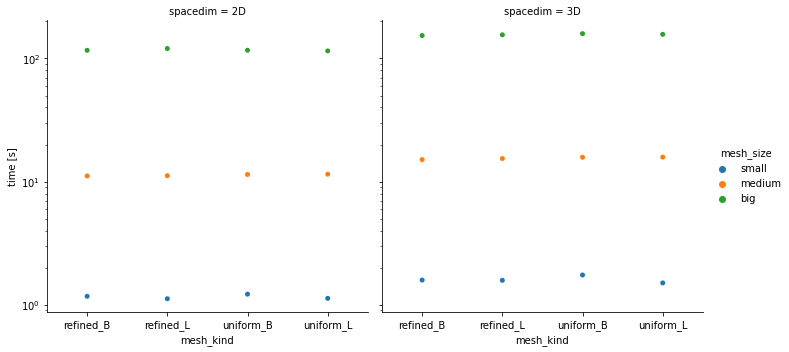

In [77]:
import seaborn as sns

def mesh_cases_plot(df):
    """
    Plot the total test time as a function of 
    8 mesh cases (2 uniformity * 2 shape * 2 dimension)
    and mesh_size.
    Normalization by number of mesh elements (or number of function calls) is necessary. 
    """  
    df_plain = df.reset_index()
    print(df_plain['tag'].unique())

    df_plain = df_plain[df_plain['tag'] == 'full_mesh']
    
    df_plain['mesh_kind'] = df_plain['uniformity'] + "_" + df_plain['domain_shape']
    fgrid = sns.catplot(x='mesh_kind', y='time', hue='mesh_size', 
                col='spacedim', kind='swarm', data=df_plain)
    fgrid.set_ylabels('time [s]')
    fgrid.set(yscale='log')
mesh_cases_plot(df_sumrun)

,commit,run_id,domain_shape,uniformity,spacedim,mesh_size,field_variant,assembly_variant,assembly_class,tag,integral_type,time,time_fraction,time_fraction_of_reminder,assembly,n_elements,n_calls
1039,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,StiffnessAssembly,None,0.419191,0.000000,0.067148,Stiffness,1000,0.1
1040,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,create_patch,None,0.016046,0.038278,0.000000,Stiffness,1000,0.1
1041,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,cache_update,None,0.004211,0.010046,0.000000,Stiffness,1000,0.1
1042,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,assemble_volume_integrals,cell,0.067765,0.161656,0.000000,Stiffness,1000,0.1
1043,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,assemble_fluxes_boundary,boundary,0.014528,0.034658,0.000000,Stiffness,1000,0.1
1044,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,assemble_fluxes_elem_elem,edge,0.288426,0.688055,0.000000,Stiffness,1000,0.1
1045,a044dad,1,B,uniform,3D,small,const,FullAssembly,StiffnessAssembly,assemble_fluxes_elem_side,dimjoin,0.000067,0.000159,0.000000,Stiffness,1000,0.1
1060,a044dad,1,B,uniform,3D,small,const,ComputeLocal,StiffnessAssembly,StiffnessAssembly,None,0.341010,0.000000,0.076213,Stiffness,1000,0.1
1061,a044dad,1,B,uniform,3D,small,const,ComputeLocal,StiffnessAssembly,create_patch,None,0.015920,0.046685,0.000000,Stiffness,1000,0.1
1062,a044dad,1,B,uniform,3D,small,const,ComputeLocal,StiffnessAssembly,cache_update,None,0.004137,0.012132,0.000000,Stiffness,1000,0.1


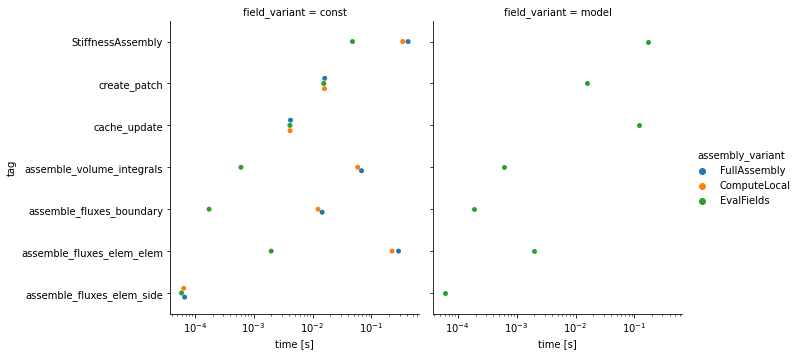

In [23]:
"""
Preliminary results:
- create_patch and cache_update are independent of assembly variant, can use mean value of these
- assembly is independent of field_update kind

- create_patch is takes significantly more then const field update
- empty assembly (just iterate over pathc elements) dominated by edge integral 
  pass 
- need some mesh with dimjoins

TODO:
- reminder = Assembly tag - other 6 subtags x 4 assembly variants
- patch = mean over assembly variants and field_kind
- f_const = mean over assembly variants field_kind == const
- f_model = field_kind == model
- integral (cell, edge, boundary, dimjoin) x phase (loop, local, assembly)
  

- 4 assembly variants: f_const, f_model, local=ComputeLocal - f_const, full = FullAssembly  - ComputeLocal
- 7 tags: patch, cache, cell, edge, boundary, dimjoin, reminder
- further simplify the cartesian product to:
    - patch (mean over assembly)
"""

dd = df[df.assembly_class == 'StiffnessAssembly']
dd = dd[dd.spacedim == '3D']
dd = dd[dd.uniformity == 'uniform']
dd = dd[dd.mesh_size == 'small']
dd = dd[dd.domain_shape == 'B']
dd = dd[dd.run_id == 1]
display(dd)

import seaborn as sns
def single_assembly_items(df):
    """
    Plot the total test time as a function of 
    8 mesh cases (2 uniformity * 2 shape * 2 dimension)
    and mesh_size.
    Normalization by number of mesh elements (or number of function calls) is necessary. 
    """  
    fgrid = sns.catplot(y='tag', x='time', hue='assembly_variant', 
                col='field_variant', kind='swarm', data=df)
    fgrid.set_xlabels('time [s]')
    fgrid.set(xscale='log')

def assembly_blocks(df):
    """
    For every XYZAssembly tag:
    - collect corresponding subtags for both field
    - patch 
    """
    pass
single_assembly_items(dd)

In [12]:
# Print values of distrete columns:
for c in df.columns:
    if df[c].dtype.name == 'object':
        print(c, '  values:', df[c].unique())

commit   values: ['a044dad']
domain_shape   values: ['B' 'L']
uniformity   values: ['uniform' 'refined']
spacedim   values: ['2D' '3D']
mesh_size   values: ['small' 'medium' 'big']
field_variant   values: [nan 'const' 'model']
assembly_variant   values: [nan 'FullAssembly' 'ComputeLocal' 'EvalFields']
assembly_class   values: [nan 'MassAssembly' 'StiffnessAssembly' 'SourcesAssembly']
tag   values: ['full_mesh' 'MassAssembly' 'create_patch' 'cache_update'
 'assemble_volume_integrals' 'assemble_fluxes_boundary'
 'assemble_fluxes_elem_elem' 'assemble_fluxes_elem_side'
 'StiffnessAssembly' 'SourcesAssembly']
integral_type   values: [None 'cell' 'boundary' 'edge' 'dimjoin']
assembly   values: [None 'Mass' 'Stiffness' 'Sources']


# Confirm duplicity of tag and integral

In [11]:
tag_int_code_pairs = [
    ('assemble_volume_integrals', 'cell'),
    ('assemble_fluxes_boundary', 'boundary'),
    ('assemble_fluxes_elem_elem', 'edge'),
    ('assemble_fluxes_elem_side', 'dimjoin')]
for tag,integral in tag_int_code_pairs:
    mask = df['tag'] == tag
    print(tag, '==' , integral, all(df.loc[mask, 'integral_type'] == integral))

assemble_volume_integrals == cell True
assemble_fluxes_boundary == boundary True
assemble_fluxes_elem_elem == edge True
assemble_fluxes_elem_side == dimjoin True


code : patch, field const, field model, local, assembly
integral (subfactor for local and assembly): cell, edge, boundary, dimjoin
together 3 + 4 + 4 code sections

assembly: Stiffness, Mass, Sources
mesh_type: 8
mesh_size: 3

hypotheses:
patch and fields independent of integral and mesh type
local and assembly 

view:
code as portions of a bar graph


{'Whole Program': {'square_2D_uniform': {'small': {'FullAssembly_const': {'BaseMeshReader - mesh factory': {'MESH - optimizer': {}, 'MESH - setup topology': {'duplicate_nodes': {}, 'Mesh::output_internal_ngh_data': {}}}, 'ZERO-TIME STEP': {'data initialize': {}, 'assembly': {'StiffnessAssembly': {'create_patch': {}, 'cache_update': {}, 'assemble_volume_integrals': {}, 'assemble_fluxes_boundary': {}, 'assemble_fluxes_elem_elem': {}, 'assemble_fluxes_elem_side': {}}, 'MassAssembly': {'create_patch': {}, 'cache_update': {}, 'assemble_volume_integrals': {}, 'assemble_fluxes_boundary': {}, 'assemble_fluxes_elem_elem': {}, 'assemble_fluxes_elem_side': {}}, 'SourcesAssembly': {'create_patch': {}, 'cache_update': {}, 'assemble_volume_integrals': {}, 'assemble_fluxes_boundary': {}, 'assemble_fluxes_elem_elem': {}, 'assemble_fluxes_elem_side': {}}}}, 'SIMULATION-ONE STEP': {'data reinit': {}, 'assembly': {'MassAssembly': {'create_patch': {}, 'cache_update': {}, 'assemble_volume_integrals': {}, '

AttributeError: 'float' object has no attribute 'items'

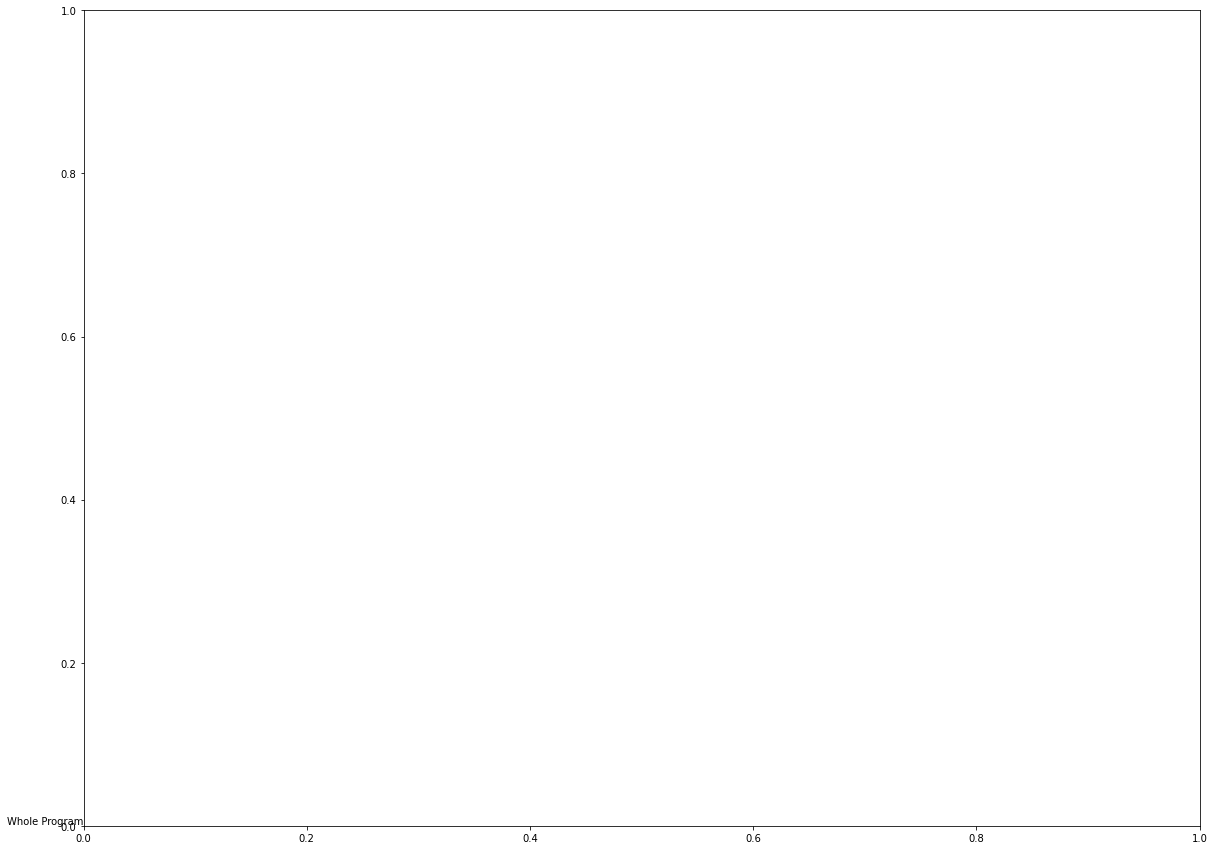

In [105]:
import json
# Display program tag-tree from original profiler output
def load_profiler(fname):
    with open(fname, 'r') as f:
        content = json.load(f)
    return content
        
prof = load_profiler(input_file_base + ".json")

def none_fn(node):
    return None

def iter_prof(node, fn = none_fn):
    childs = node.get('children', [])
    d = {c['tag']: iter_prof(c) for c in childs}
    node_value = fn(node)
    if node_value is not None:
        d['!value'] = node_value 
    return d

def tag_dict(root_node):
    return iter_prof(root_node)

import matplotlib.pyplot as plt

def plot_tree(ax, d, x=0, y=0, level_height=0.1, x_offset=0.1):
    for key, value in d.items():
        ax.text(x, y, key, verticalalignment='bottom', horizontalalignment='right')
        
        new_y = y - level_height

        if isinstance(value, dict):
            #ax.plot([x, x + x_offset], [y - 0.1, new_y + 0.1], 'k-')  # Vertical line
            #ax.plot([x, x + x_offset], [new_y + 0.1, new_y + 0.1], 'k-')  # Horizontal line

            plot_tree(value, x + x_offset, new_y, level_height, x_offset, ax)

        y = new_y
    ax.axis('off')    
    
def display_code(prof):
    fig, ax = plt.subplots(figsize=(20,15))
    plot_tree(ax, prof)
    return fig, ax

td = tag_dict(prof)
print(td)
fig, ax = display_code(td)
plt.show()

In [ ]:
See if we have any large unidentified blocks

The code structure is like:
    - full_mesh
       - some other stuff (should be minor)
       - MassAssembly
       - SourcesAssembly
       - StiffnessAssembly 

In [70]:
def full_mesh(df):
    df2 = df[df['tag'] == 'full_mesh'].copy()
    df2.dropna(axis='columns', how='all', inplace=True)
    return df2
    
df_full_mesh = full_mesh(df)
display(df_full_mesh)

,commit,run_id,domain_shape,uniformity,spacedim,mesh_size,tag,time,n_elements,n_calls
0,a044dad,1,B,uniform,2D,small,full_mesh,1.219523,1000,0.1
1,a044dad,1,B,uniform,2D,medium,full_mesh,11.433362,2000,1.0
2,a044dad,1,B,uniform,2D,big,full_mesh,116.670933,3000,1.0
3,a044dad,1,B,refined,2D,small,full_mesh,1.171866,1000,0.1
4,a044dad,1,B,refined,2D,medium,full_mesh,11.120954,2000,1.0
...,...,...,...,...,...,...,...,...,...,...
4099,a044dad,3,L,uniform,3D,medium,full_mesh,15.806246,2000,1.0
4100,a044dad,3,L,uniform,3D,big,full_mesh,157.303360,3000,1.0
4101,a044dad,3,L,refined,3D,small,full_mesh,1.577268,1000,0.1
4102,a044dad,3,L,refined,3D,medium,full_mesh,15.284970,2000,1.0


Goals of analysis:
- time of individual phases: field_const, field_model, local_matrix, assembly
  as function of the mesh size; Use ANOVA to see if the shape or uniformity of the domain 
  affects the time
- plot total mesh time as function of (mesh type (uniformity, dimension, shape), mesh_size)
- collect mesh types that seems to behave in the same way

  log T = log mu_{cases,tag} + log mu_size
  vs. interaction so the tags scale differently with size (different portion of the const overhead)
  
Improve the collectiong process:
- fix the column names
- add #calls column 

In [56]:
from collections import defaultdict

def check_same(x, y):
    if x != y:
        return None
    return x

def my_med(x):
    print(x)
    return np.median(x)

def median_keep_nan(series):
    if all(pd.isna(series)):
        return np.nan
    return series.median()
    
def aggregate_runs(df, columns, op=median_keep_nan):
    # how to apply common function to all other columns
    operation_col_dict = defaultdict(lambda : check_same)
    for c in time_cols & set(df.columns):
        operation_col_dict[c] = op
    
    
    group_by_cols = set(df.columns.values) - {'run_id'} - time_cols
    groups = df.groupby(list(group_by_cols))
    #for name, group in groups:
    #    print(name)
    #    print(group)
    return groups.agg(operation_col_dict)

time_cols = {'time', 'time_fraction', 'time_fraction_of_reminder'}

df = df.reset_index()
df_sumrun = aggregate_runs(df, time_cols)
display(df_sumrun.reset_index())
#df_sumrun.columns
#print(df_sumrun.index.get_level_values('tag').unique())

,n_calls,assembly_variant,domain_shape,commit,Variants,tag,field_variant,n_elements,mesh_size,uniformity,integral_type,spacedim,index,assembly,time,time_fraction,time_fraction_of_reminder
0,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,301,Mass,0.000012,0.000732,0.0
1,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,308,Stiffness,0.005128,0.019570,0.0
2,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,315,Sources,0.000012,0.001139,0.0
3,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,2341,Mass,0.000012,0.000709,0.0
4,0.1,ComputeLocal,B,a044dad,const_ComputeLocal,assemble_fluxes_boundary,const,1000,small,refined,boundary,2D,2348,Stiffness,0.005154,0.019421,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,1.0,FullAssembly,L,a044dad,const_FullAssembly,assemble_volume_integrals,const,3000,big,uniform,cell,3D,3754,Stiffness,6.155830,0.158154,0.0
3452,1.0,FullAssembly,L,a044dad,const_FullAssembly,assemble_volume_integrals,const,3000,big,uniform,cell,3D,3761,Sources,1.167425,0.694035,0.0
3453,1.0,FullAssembly,L,a044dad,const_FullAssembly,assemble_volume_integrals,const,3000,big,uniform,cell,3D,5787,Mass,3.411887,0.870409,0.0
3454,1.0,FullAssembly,L,a044dad,const_FullAssembly,assemble_volume_integrals,const,3000,big,uniform,cell,3D,5794,Stiffness,6.198350,0.158468,0.0


In [27]:
d2 = pd.DataFrame(df)
d2['mesh_kind'] = d2['uniformity'] + "_" + d2['domain_shape']

In [28]:
display(df)

,commit,run_id,domain_shape,uniformity,spacedim,mesh_size,n_repeats,field_variant,assembly_variant,assembly_class,tag,integral_type,time,time_fraction,time_fraction_of_reminder,n_elements,n_calls,mesh_kind
0,a044dad,1,square,uniform,2D,small,10,NaN,NaN,NaN,full_mesh,NaN,12.195230,NaN,NaN,1000,1,uniform_square
1,a044dad,1,square,uniform,2D,medium,1,NaN,NaN,NaN,full_mesh,NaN,11.433362,NaN,NaN,2000,1,uniform_square
2,a044dad,1,square,uniform,2D,big,1,NaN,NaN,NaN,full_mesh,NaN,116.670933,NaN,NaN,3000,1,uniform_square
3,a044dad,1,square,refined,2D,small,10,NaN,NaN,NaN,full_mesh,NaN,11.718664,NaN,NaN,1000,1,refined_square
4,a044dad,1,square,refined,2D,medium,1,NaN,NaN,NaN,full_mesh,NaN,11.120954,NaN,NaN,2000,1,refined_square
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,a044dad,3,lshape,refined,3D,big,1,model,EvalFields,SourcesAssembly,cache_update,NaN,0.106648,0.157467,0.0,3000,1,refined_lshape
6116,a044dad,3,lshape,refined,3D,big,1,model,EvalFields,SourcesAssembly,assemble_volume_integrals,cell_integral,0.042696,0.063042,0.0,3000,1,refined_lshape
6117,a044dad,3,lshape,refined,3D,big,1,model,EvalFields,SourcesAssembly,assemble_fluxes_boundary,boundary_side_integral,0.001640,0.002421,0.0,3000,1,refined_lshape
6118,a044dad,3,lshape,refined,3D,big,1,model,EvalFields,SourcesAssembly,assemble_fluxes_elem_elem,edge_integral,0.001548,0.002286,0.0,3000,1,refined_lshape


In [26]:
def mesh_cases_anova(df):
    """
    
    all_mesh_time/ = log mu_{cases,tag} + log mu_size
    """


Clearly there is a negligeble overall difference between the meshes. Let's try ANOVA for different 'tag' and 'assembly_variant' cases.